## imports & paths & environ

In [1]:
%matplotlib inline

# Paths.py holds paths to local directories and is excluded from git 
# this allows for notebook synv without endless change of path 
import Paths

import numpy as np
import skimage.io as io
import numpy as np
import tensorflow as tf
import sys
import glob
import os
from matplotlib import pyplot as plt
from __future__ import division

sys.path.append(Paths.slimModelAppend)

from nets import vgg
from preprocessing import vgg_preprocessing

# Load the mean pixel values and the function
# that performs the subtraction from each pixel
from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                             _R_MEAN, _G_MEAN, _B_MEAN)

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

## helper functions

In [2]:
def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """

    filter_size = get_kernel_size(factor)

    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)

    upsample_kernel = upsample_filt(filter_size)

    for i in xrange(number_of_classes):
        weights[:, :, i, i] = upsample_kernel

    return weights

## ground truth / annotation loading and placeholders

In [3]:
# necessary just to get model started
imagesFolder = '/Users/galmoore/Wounds_Image_Database/TESTVAL_ONLY/Images_test'
predictForImg = imagesFolder + '/Images00000.jpg'
predictForAnot = '/Users/galmoore/Wounds_Image_Database/TESTVAL_ONLY/Groundtruth_fcn_msk/msk00000.png'

# image and mask file size must be: 480 x 352
image_filename = predictForImg
annotation_filename = predictForAnot

# placeholder is a tensor that must be fed
image_filename_placeholder = tf.placeholder(tf.string)
annotation_filename_placeholder = tf.placeholder(tf.string)
is_training_placeholder = tf.placeholder(tf.bool)

# feed_dict is argument to tf.Session.run: here providing image, annotation and bool
feed_dict_to_use = {image_filename_placeholder: image_filename
                   ,annotation_filename_placeholder: annotation_filename
                   ,is_training_placeholder: True}

# read actual contents into tensors
image_tensor = tf.read_file(image_filename_placeholder)
annotation_tensor = tf.read_file(annotation_filename_placeholder)

## decode a jpg/png encoded image to output a uint8 tensor 
# channels=: 0 (use existing # of channels) / 1 (grayscale image) / 3 (RGB image)
image_tensor = tf.image.decode_jpeg(image_tensor,channels=3)
annotation_tensor = tf.image.decode_png(annotation_tensor,channels=1)

## When run get labels from annotation

In [4]:
# Get ones for each class instead of a number -- we need that
# for cross-entropy loss later on. Sometimes the groundtruth
# masks have values other than 1 and 0.
class_labels_tensor = tf.equal(annotation_tensor, 1)
background_labels_tensor = tf.not_equal(annotation_tensor, 1)

# Convert the boolean values into floats -- so that
# computations in cross-entropy loss is correct
bit_mask_class = tf.to_float(class_labels_tensor)
bit_mask_background = tf.to_float(background_labels_tensor)

# Concatinate tensors along one dimension: 
combined_mask = tf.concat(axis=2
                         ,values=[bit_mask_class
                                 ,bit_mask_background])

# Lets reshape our input so that it becomes suitable for
# tf.softmax_cross_entropy_with_logits with [batch_size, num_classes]
flat_labels = tf.reshape(tensor=combined_mask, shape=(-1, 2))

## preperation

In [5]:
slim = tf.contrib.slim

# Convert image to float32 before subtracting the
# mean pixel value
image_float = tf.to_float(image_tensor, name='ToFloat')

# Subtract the mean pixel value from each pixel
mean_centered_image = _mean_image_subtraction(image_float,
                                              [_R_MEAN, _G_MEAN, _B_MEAN])

## Now we have image with each pixel as average of RGB
## expand_dims() inserts a dimension of 1 into a tensor's shape at specified index
processed_images = tf.expand_dims(mean_centered_image, 0)

upsample_factor = 32
number_of_classes = 2

# Create weights matrix (np.zeros) for transposed convolution with bilinear filter initialization.
upsample_filter_np = bilinear_upsample_weights(upsample_factor,
                                               number_of_classes)

upsample_filter_tensor = tf.constant(upsample_filter_np)

# arg_scope(tf.contrib.framework.arg_scope) provides a new scope named arg_scope that allows a user
# to define default arguments for specific operations within that scope.
# here we define the model that we want to use -- specify to use only two classes at the last layer
with slim.arg_scope(vgg.vgg_arg_scope()):
    logits, end_points = vgg.vgg_16(processed_images,
                                    num_classes=2,
                                    is_training=is_training_placeholder,
                                    spatial_squeeze=False,
                                    fc_conv_padding='SAME')

downsampled_logits_shape = tf.shape(logits)

# Calculate the ouput size of the upsampled tensor
upsampled_logits_shape = tf.stack([
    downsampled_logits_shape[0],
    downsampled_logits_shape[1] * upsample_factor,
    downsampled_logits_shape[2] * upsample_factor,
    downsampled_logits_shape[3]
])

# Perform the upsampling
upsampled_logits = tf.nn.conv2d_transpose(logits
                                          ,upsample_filter_tensor
                                          ,output_shape=upsampled_logits_shape
                                          ,strides=[1
                                                    ,upsample_factor
                                                    ,upsample_factor
                                                    ,1])

# Flatten the predictions, so that we can compute cross-entropy for
# each pixel and get a sum of cross-entropies
# tf.reshape() Given tensor, this operation returns a tensor that has the same values as tensor with shape shape.
# a shape of [-1] flattens into 1-D.
flat_logits = tf.reshape(tensor=upsampled_logits, shape=(-1, number_of_classes))

## Computes softmax cross entropy between logits (prediction) and labels (which class).
## Measures the probability error in discrete classification tasks
cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits,
                                                          labels=flat_labels)

# tf.reduce_sum(input_tensor):
# 'x' is [[1, 1, 1]
#         [1, 1, 1]]
# tf.reduce_sum(x) ==> 6
cross_entropy_sum = tf.reduce_sum(cross_entropies)

# Tensor to get the final prediction for each pixel
pred = tf.argmax(upsampled_logits, dimension=3)

# Tensor to get probabilities for each pixel
probabilities = tf.nn.softmax(upsampled_logits)

# optimizer.compute_gradients and optimizer.apply_gradients
# is equivalent to running:
# train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cross_entropy_sum)
with tf.variable_scope("adam_vars"):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    gradients = optimizer.compute_gradients(loss=cross_entropy_sum)

    for grad_var_pair in gradients:
        current_variable = grad_var_pair[1]
        current_gradient = grad_var_pair[0]

        # Replace some characters from the original variable name
        # tensorboard doesn't accept ':' symbol
        gradient_name_to_save = current_variable.name.replace(":", "_")

        # Let's get histogram of gradients for each layer and
        # visualize them later in tensorboard
        tf.summary.histogram(gradient_name_to_save, current_gradient)

    train_step = optimizer.apply_gradients(grads_and_vars=gradients)
    
# Put all summary ops into one op. Produces string when
# you run it.
merged_summary_op = tf.summary.merge_all()

## visualisation setup

In [6]:
fig_size = [15, 4]
plt.rcParams["figure.figsize"] = fig_size

## load weights when called

In [7]:
vgg_except_fc8_weights = slim.get_variables_to_restore(exclude=['vgg_16/fc8', 'adam_vars'])
vgg_fc8_weights = slim.get_variables_to_restore(include=['vgg_16/fc8'])

# Gets the list of the variables to restore - include the variables from 'adam_vars'
adam_optimizer_variables = slim.get_variables_to_restore(include=['adam_vars'])

## Create an OP that performs the initialization of
## values of variables to the values from VGG.
read_vgg_weights_except_fc8_func = slim.assign_from_checkpoint_fn(
                                                                  Paths.checkpointString,
                                                                  vgg_except_fc8_weights)

# Initializer for new fc8 weights -- for two classes.
vgg_fc8_weights_initializer = tf.variables_initializer(vgg_fc8_weights)

# Initializer for adam variables
optimization_variables_initializer = tf.variables_initializer(adam_optimizer_variables)

## restore model from here:

In [8]:
firstPartPathModel = '/Users/galmoore/anaconda/envs/Healthy2.7/SpotSegmentation/TensorFlow_Segmentation'
RestoreModelFromHere = firstPartPathModel + '/Gush_Models/V9_Epoch_34/model'


## Create list of paths to all img files in folder 

In [9]:
folderPath = '/Users/galmoore/Wounds_Image_Database/TESTVAL_ONLY/small_test_20/imgs/'

paths = glob.glob(folderPath + '*')

# check if not more than 20 files
numberOfimagesInFolder = len(glob.glob1(folderPath,"*"))
if numberOfimagesInFolder > 20:
    sys.exit("aa! more than 20 files in that folder!")
    

## Create list of paths to all anot files in folder

In [10]:
mskfolderPath = '/Users/galmoore/Wounds_Image_Database/TESTVAL_ONLY/small_test_20/msks_resized_format_change/'
mskpaths = glob.glob(mskfolderPath + '*')


## run session

INFO:tensorflow:Restoring parameters from /Users/galmoore/anaconda/envs/tensorflow/vgg_16.ckpt
INFO:tensorflow:Restoring parameters from /Users/galmoore/anaconda/envs/Healthy2.7/SpotSegmentation/TensorFlow_Segmentation/Gush_Models/V9_Epoch_34/model


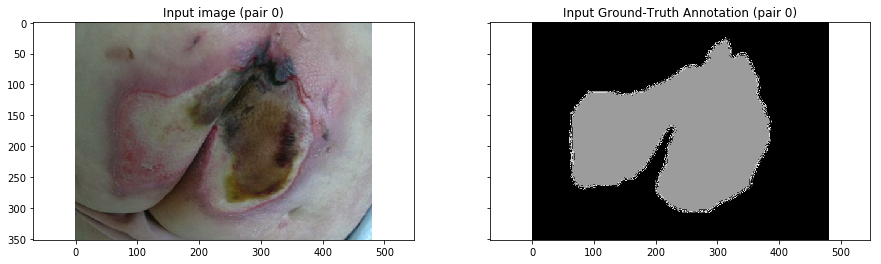

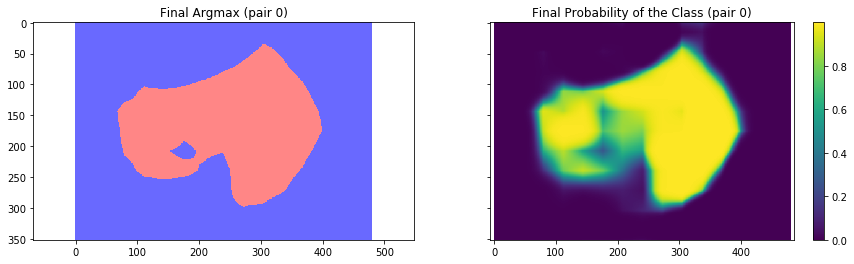

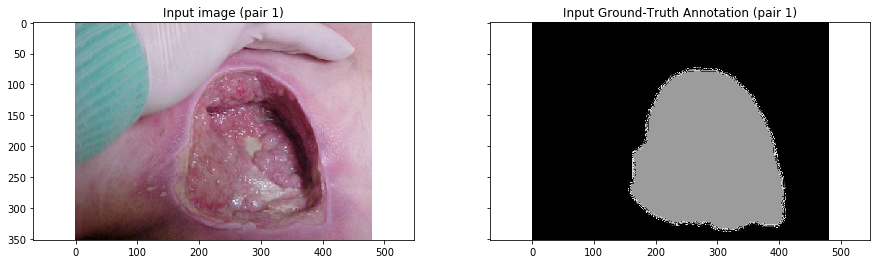

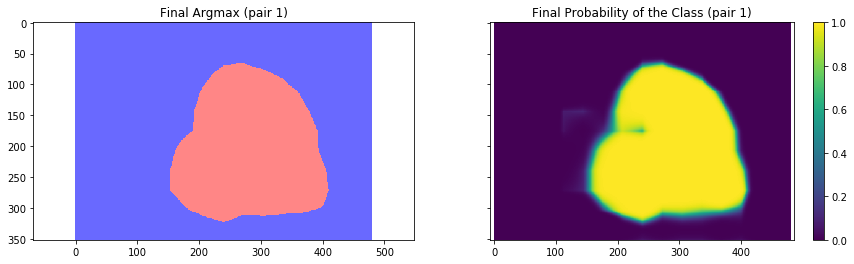

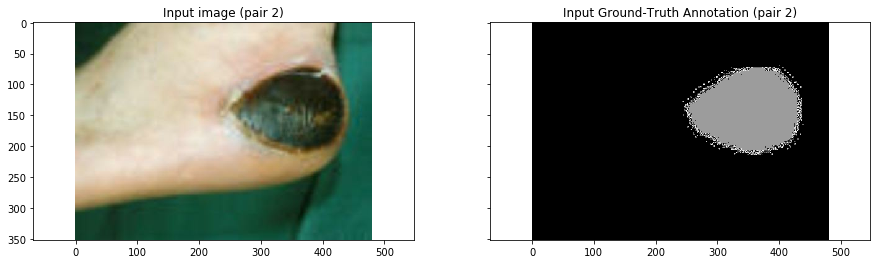

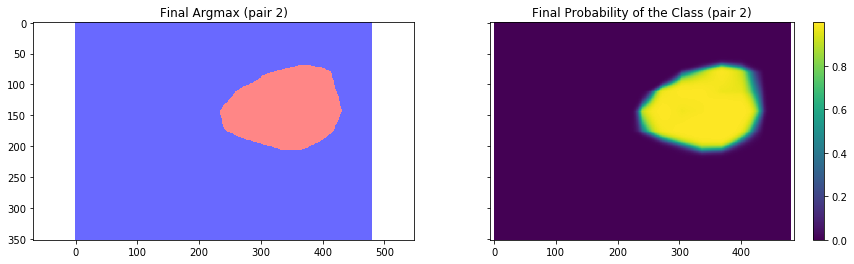

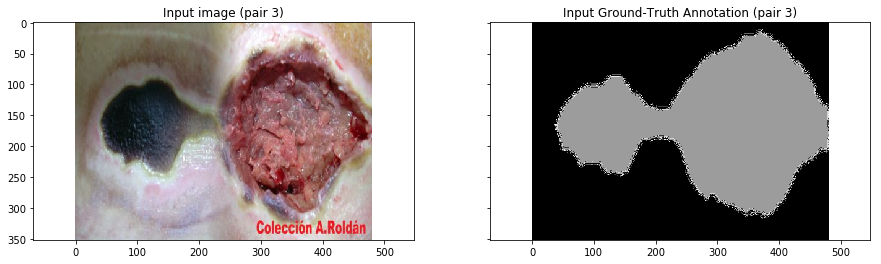

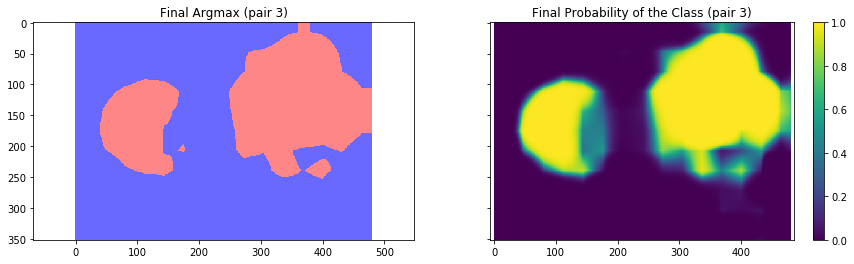

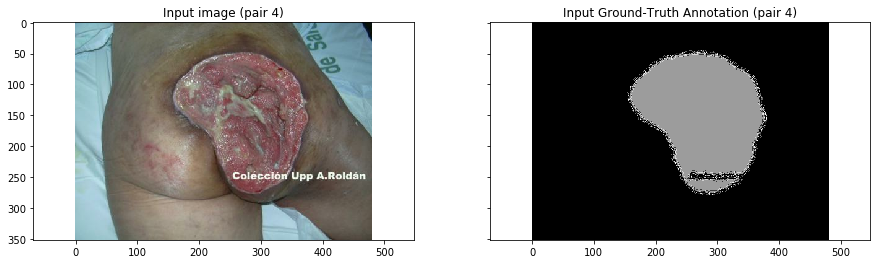

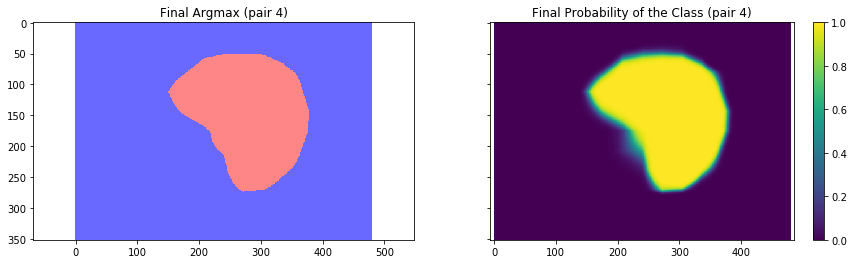

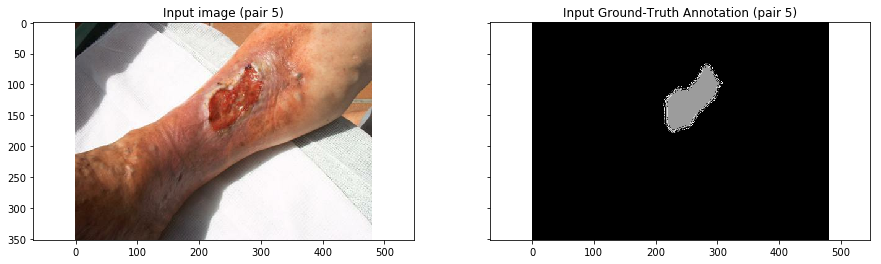

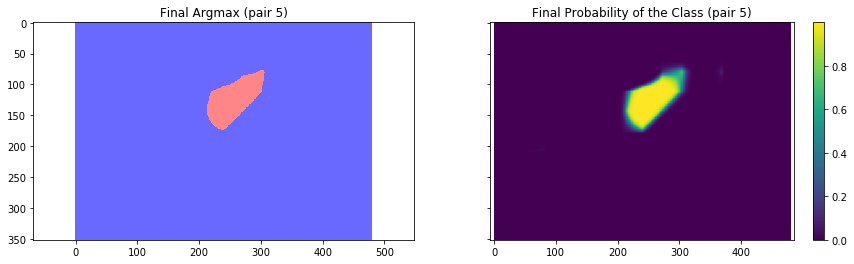

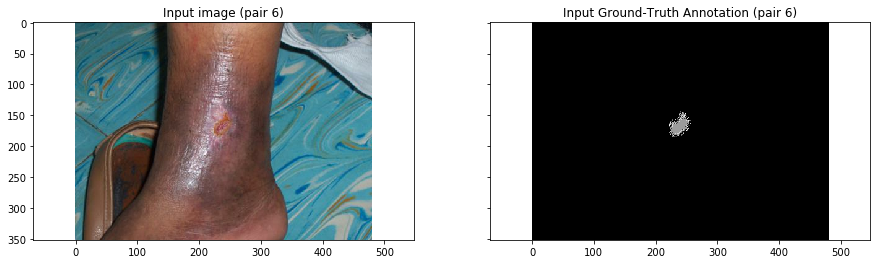

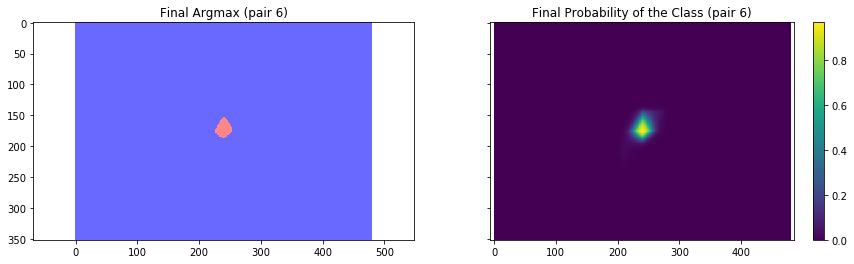

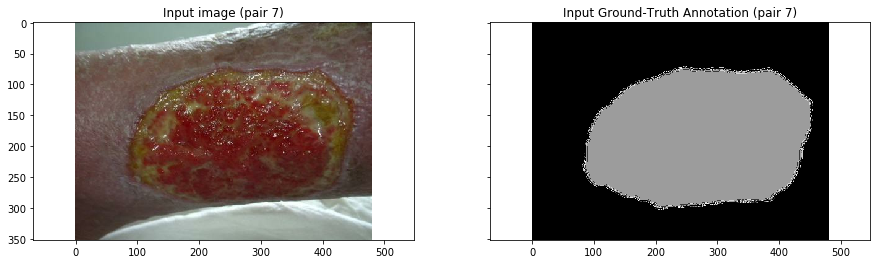

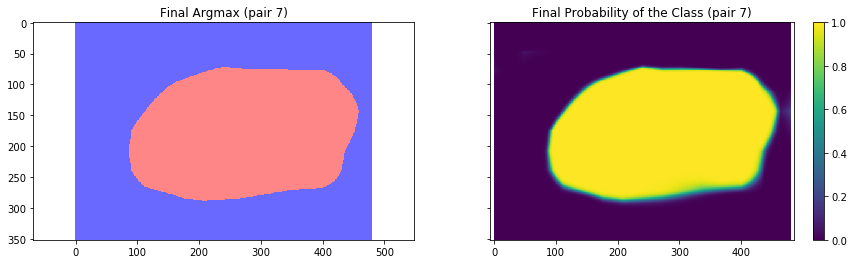

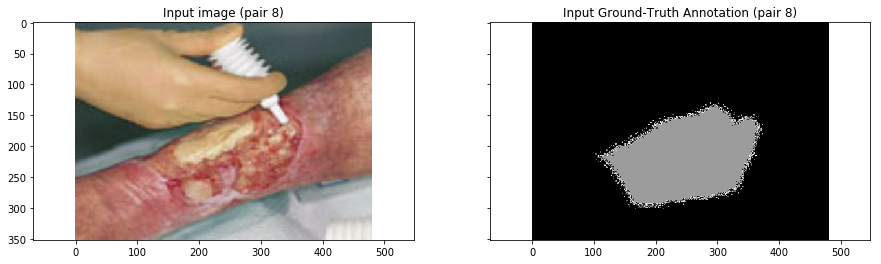

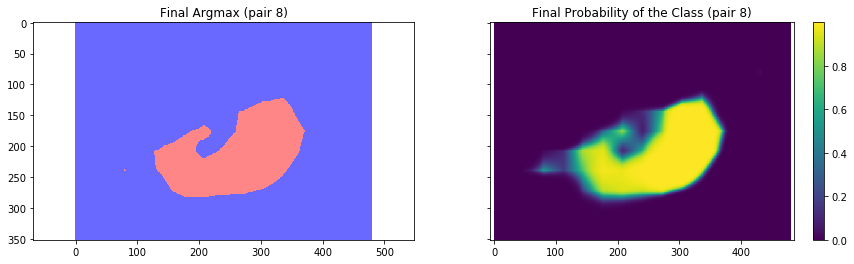

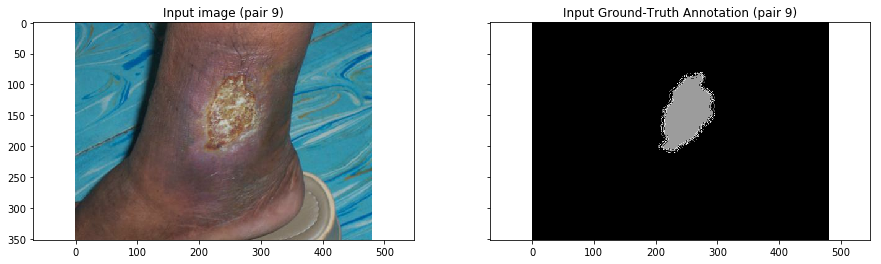

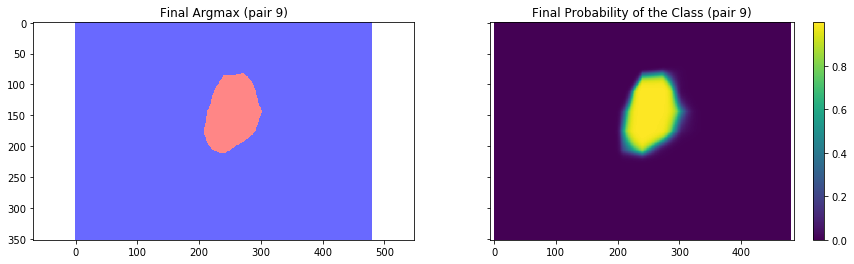

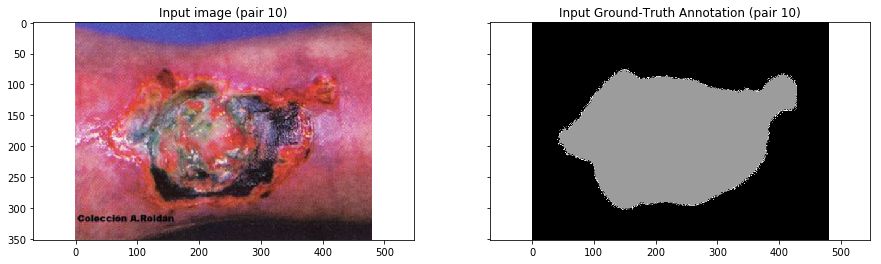

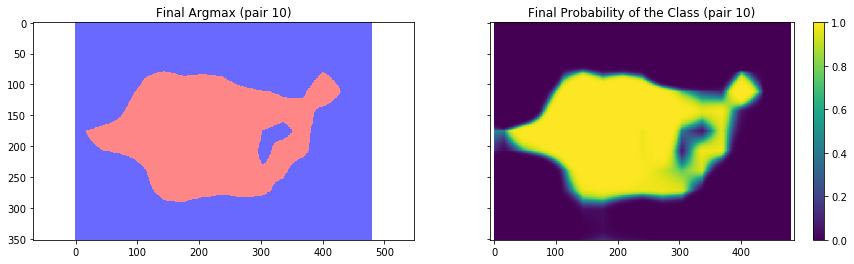

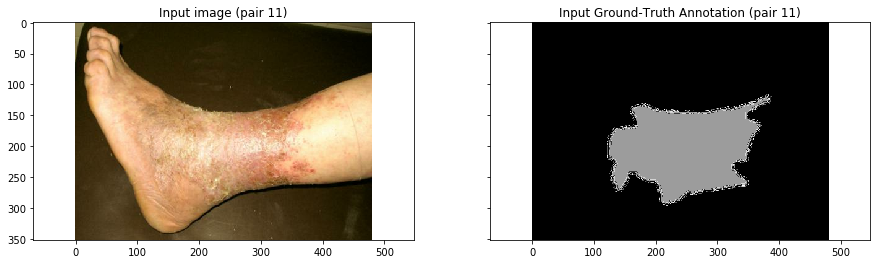

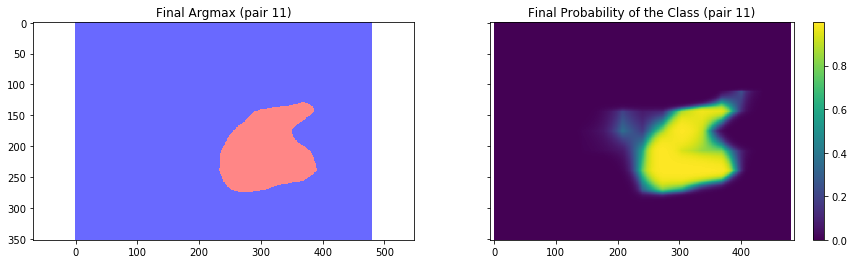

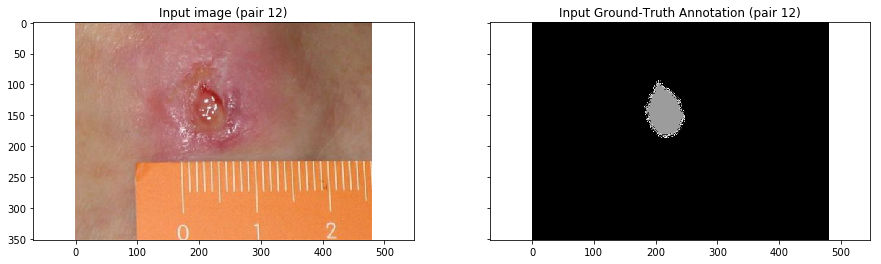

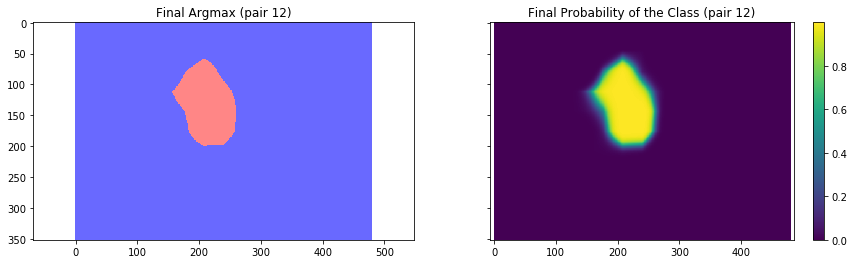

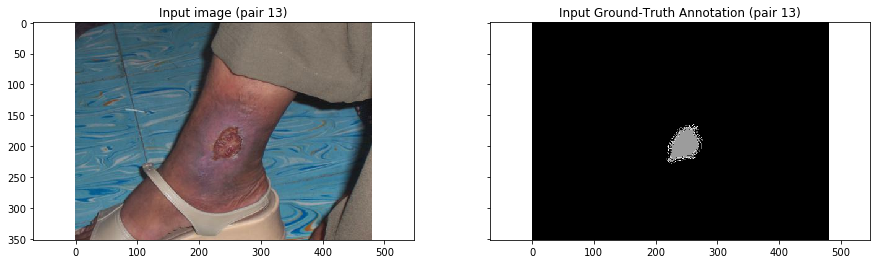

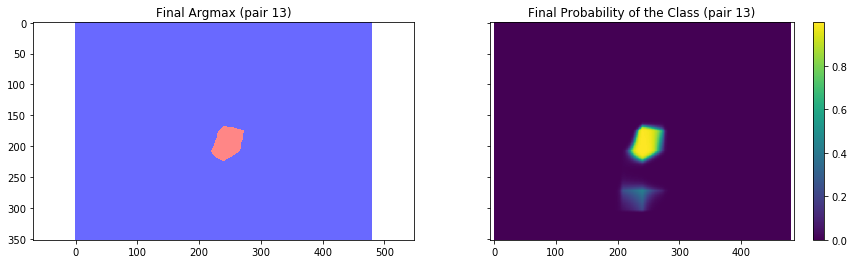

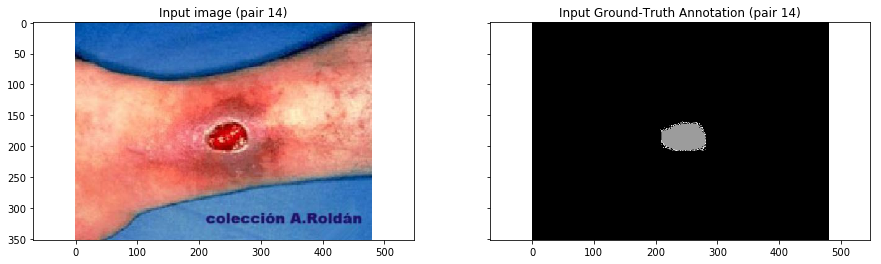

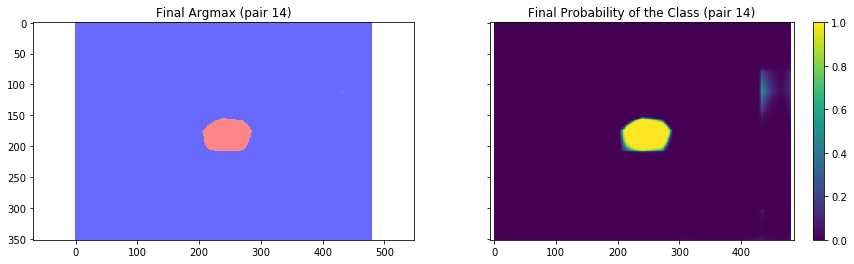

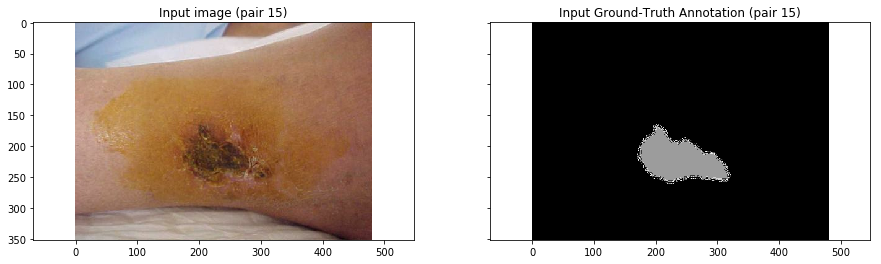

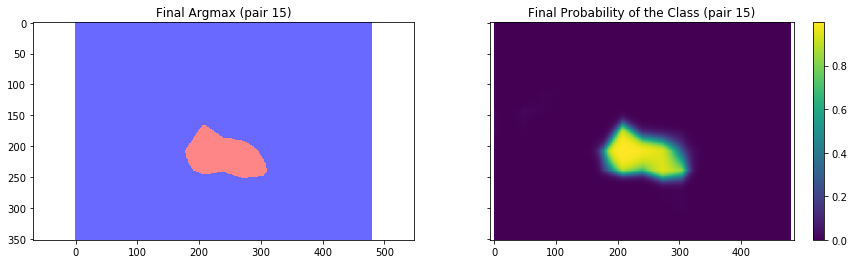

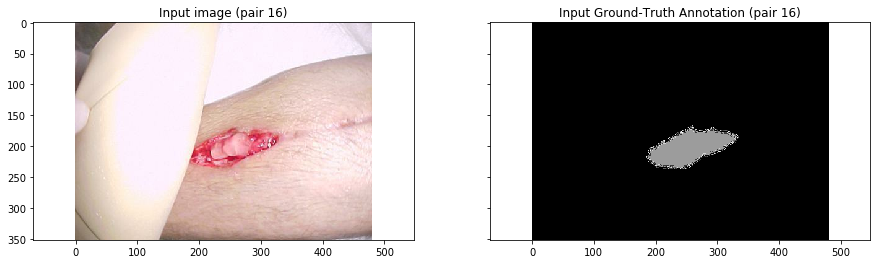

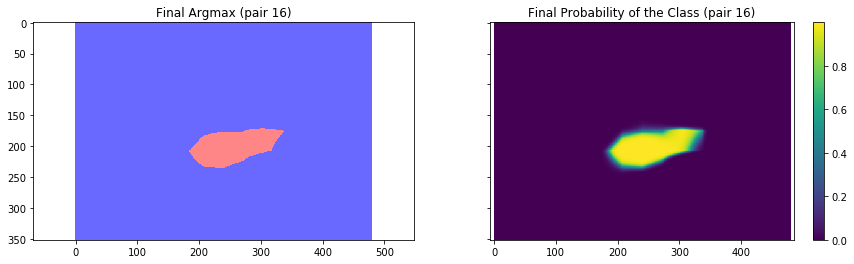

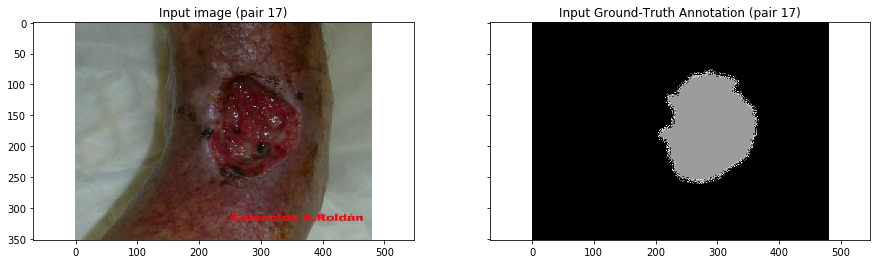

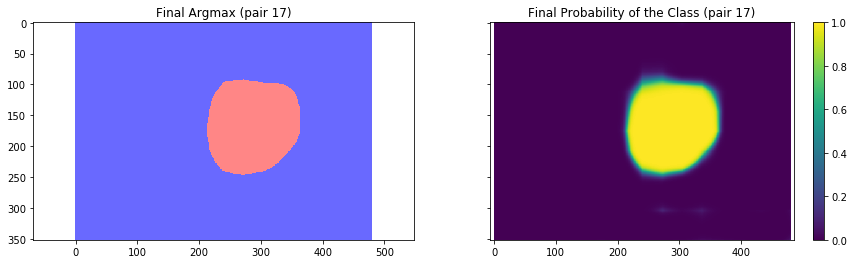

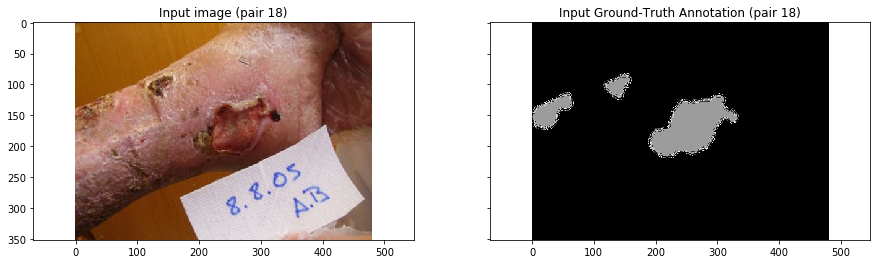

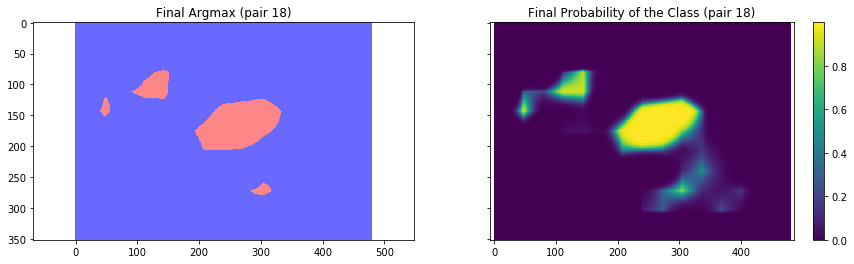

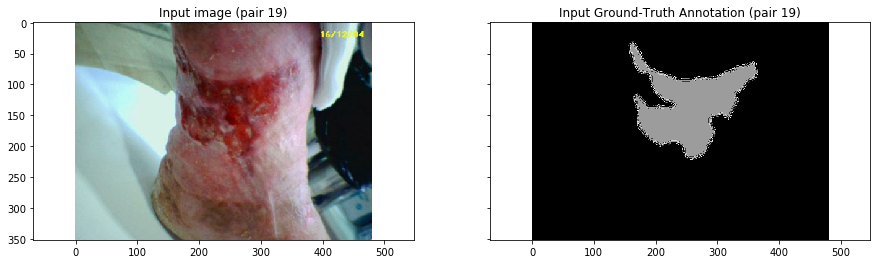

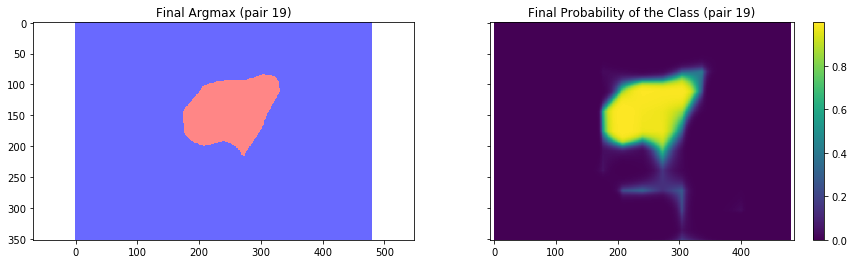

In [11]:
with tf.Session() as sess:
    
    # Run the initializers.
    read_vgg_weights_except_fc8_func(sess)
    sess.run(vgg_fc8_weights_initializer)
    sess.run(optimization_variables_initializer)
    
    ########### RESTORE THE MODEL ###########
    # create saver
    saver = tf.train.Saver()

    # restore model
    saver.restore(sess, RestoreModelFromHere)
    ####################################### 
    
    # show the i pairs before prediction
    for i in range(numberOfimagesInFolder): # prints till number in range (i.e range = 4 = 0,1,2,3)
        image_filename = paths[i]
        annotation_filename = mskpaths[i]
    
        feed_dict_to_use = {image_filename_placeholder: image_filename
                        ,annotation_filename_placeholder: annotation_filename
                        ,is_training_placeholder: True}
        
        train_image, train_annotation = sess.run([image_tensor
                                             ,annotation_tensor]
                                             ,feed_dict=feed_dict_to_use)
    
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        ax1.imshow(train_image)
        ax1.set_title('Input image (pair ' + str(i) + ')' )
        probability_graph = ax2.imshow(np.dstack((train_annotation,) * 3) * 100)
        ax2.set_title('Input Ground-Truth Annotation (pair ' + str(i) + ')')
        plt.show()   

        #

        image_filename = paths[i]
        annotation_filename = mskpaths[i]

        feed_dict_to_use = {image_filename_placeholder: image_filename
                            ,annotation_filename_placeholder: annotation_filename
                            ,is_training_placeholder: True}

        ########
        feed_dict_to_use[is_training_placeholder] = False
        ########

        ## Visualisation final prediction for pair i ##
        final_predictions, final_probabilities, final_loss = sess.run([pred 
                                                                      ,probabilities
                                                                      ,cross_entropy_sum]
                                                                      ,feed_dict=feed_dict_to_use)

        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

        # cmap added //  was missing cause for loop 10 iterations commented out!

        cmap = plt.get_cmap('bwr')

        ax1.imshow(np.uint8(final_predictions.squeeze() != 1),
                   vmax=1.5,
                   vmin=-0.4,
                   cmap=cmap)

        ax1.set_title('Final Argmax (pair ' + str(i) + ')')

        probability_graph = ax2.imshow(final_probabilities.squeeze()[:, :, 0])
        ax2.set_title('Final Probability of the Class (pair ' + str(i) + ')' )
        plt.colorbar(probability_graph)

        plt.show()
